In this notebook the [BoardGame Geek XML API](https://boardgamegeek.com/wiki/page/BGG_XML_API2?rnd=01536) will be examined and the required data will be downloaded.

In [4]:
%load_ext autoreload
%autoreload 2

# 1. BoardGames Ranks 

## 1.1 CSV file
As it was mentioned in the service's documentation [boardgames_ranks.csv](../data/raw/boardgames_ranks.csv) file downloaded manually.
We will be applyig our sentiment analysis for top 100 games and this file will be used to find these games

In [3]:
import pandas as pd

In [13]:
df = pd.read_csv('../data/raw/boardgames_ranks.csv')

# Have a look random samples
df.sample(5)

,id,name,yearpublished,rank,bayesaverage,average,usersrated,abstracts_rank,cgs_rank,childrensgames_rank,familygames_rank,partygames_rank,strategygames_rank,thematic_rank,wargames_rank
135384,356951,Cat Detective,2023,0,0.00000,0.0000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6967,181290,KUMO Hogosha,2015,6968,5.64061,6.6243,347,374.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53518,39112,Grand Prix Cribbage,1985,0,0.00000,6.0000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151621,412958,Swirling Heroes,2024,0,0.00000,8.0000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3322,283642,Cowboy Bebop: Space Serenade,2019,3323,5.92929,7.3931,679,NaN,NaN,NaN,NaN,NaN,1463.0,622.0,NaN


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155087 entries, 0 to 155086
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   155087 non-null  int64  
 1   name                 155087 non-null  object 
 2   yearpublished        155087 non-null  int64  
 3   rank                 155087 non-null  int64  
 4   bayesaverage         155087 non-null  float64
 5   average              155087 non-null  float64
 6   usersrated           155087 non-null  int64  
 7   abstracts_rank       1429 non-null    float64
 8   cgs_rank             359 non-null     float64
 9   childrensgames_rank  1057 non-null    float64
 10  familygames_rank     3212 non-null    float64
 11  partygames_rank      893 non-null     float64
 12  strategygames_rank   2936 non-null    float64
 13  thematic_rank        1648 non-null    float64
 14  wargames_rank        4247 non-null    float64
dtypes: float64(10), i

Unfortunately, there is no docuemntation for the CSV file. But the columns are somehow intuitive. 
To detect "top" we have 3 different alternatives. `rank`, `bayesaverage` and `average`.  
Therefore, we are not interested in the following features.
- `yearpublished`
- `abstracts_rank`
- `cgs_rank`
- `childgames_rank`
- `familygames_rank`
- `partygames_rank`
- `strategygames_rank`
- `thematic_rank`
- `wargames_rank`

In [103]:
df = df[['id', 'name', 'rank', 'bayesaverage', 'average', 'usersrated']]
df.describe(percentiles=[.10, .25, .50, .75, .90]).T

,count,mean,std,min,10%,25%,50%,75%,90%,max
id,155087.0,187867.179080,133344.176510,1.0,16896.6,42356.5,180570.0,308284.50000,372571.40000,422668.00000
rank,155087.0,2254.748851,5887.979703,0.0,0.0,0.0,0.0,0.00000,10936.40000,26445.00000
bayesaverage,155087.0,1.348053,2.421629,0.0,0.0,0.0,0.0,0.00000,5.57121,8.41602
average,155087.0,5.015685,3.040838,0.0,0.0,3.0,6.0,7.22109,8.00000,10.00000
usersrated,155087.0,184.723291,1755.218893,0.0,0.0,1.0,4.0,26.00000,151.00000,127543.00000


Obviously on all ratings there is a big skew on zero. Since we're interested in the top, let's have a look at the distributions of these ratings without zero ratings

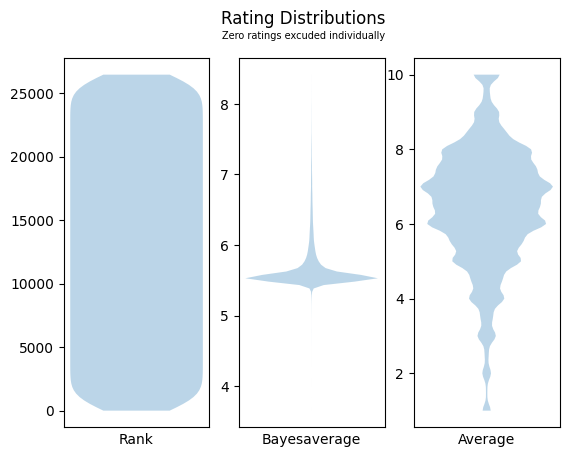

In [101]:
import matplotlib.pyplot as plt

# Plot the ranking distributions without 0 ranks
fig, ax = plt.subplots(1, 3, sharex=False)

for i, feature in enumerate(['rank', 'bayesaverage', 'average']):
    # Plot the data
    plot_data = df[[feature]].query(f'{feature} != 0')
    ax[i].violinplot(plot_data, showextrema=False)
    # Set subplots label
    ax[i].set_xlabel(f'{feature.title()}', size=10)
    # Remove x ticks
    ax[i].set_xticks([])

_ = plt.text(.5, .92, 'Zero ratings excuded individually', transform=fig.transFigure, horizontalalignment='center', size=7)
_ = fig.suptitle('Rating Distributions')

Bayes Average has the most reasonable distribution based as expected. This feature will be selected as describer for top 50.

In [109]:
df_top100 = df[['id', 'name', 'bayesaverage', 'usersrated']].sort_values('bayesaverage', ascending=False).head(100)
df_top100.head(10)

,id,name,bayesaverage,usersrated
0,224517,Brass: Birmingham,8.41602,45595
103807,247030,Terraforming Mars: Prelude,8.40415,15151
1,161936,Pandemic Legacy: Season 1,8.38053,53399
2,174430,Gloomhaven,8.35400,62047
3,342942,Ark Nova,8.33394,43124
4,233078,Twilight Imperium: Fourth Edition,8.24157,23671
5,316554,Dune: Imperium,8.22939,45119
6,167791,Terraforming Mars,8.21379,98703
7,115746,War of the Ring: Second Edition,8.18431,21255
137583,363622,The Castles of Burgundy: Special Edition,8.17803,6121


![top_10_visual_comparison](../reports/images/top10.png)

A visual comparison from [the site's ranking](https://boardgamegeek.com/browse/boardgame/page/1?sort=rank) shows that the CSV file has not only board games but also expansions. Therefore, we'll get the listing directly from the website itself

In [ ]:
del df
del df_top100

## 1.2 Direct Read from Website
Board Game Geek has a ranking page alredy. Since first option had issues, we'll continue with directly reading the page to get top 100 games

In [2]:
import pandas as pd

df = pd.read_html(
    'https://boardgamegeek.com/browse/boardgame?sort=rank&rankobjecttype=subtype&rankobjectid=1&rank=1#1', 
    extract_links="body" # To get game id's from thumbnail image address
    )[0]

In [3]:
df.shape

(106, 7)

In [4]:
df.head(2)

,Board Game Rank,Thumbnail image,Title,Geek Rating,Avg Rating,Num Voters,Shop
0,"(1, None)","(, /boardgame/224517/brass-birmingham)","(Brass: Birmingham (2018) Build networks, gr...","(8.415, None)","(8.60, None)","(45824, None)","(, None)"
1,"(2, None)","(, /boardgame/161936/pandemic-legacy-season-1)",(Pandemic Legacy: Season 1 (2015) Mutating d...,"(8.380, None)","(8.53, None)","(53479, None)","(, None)"


In [5]:
# Extract info from tuples within rows
df = df.assign(
    BOARD_GAME_RANK = lambda x: x['Board Game Rank'].apply(lambda y: y[0]),
    THUMBNAIL_ADDRESS = lambda x: x['Thumbnail image'].apply(lambda y: y[1]),
    TITLE = lambda x: x['Title'].apply(lambda y: y[0]),
    GEEK_RATING = lambda x: x['Geek Rating'].apply(lambda y: y[0]),
    AVG_RATING = lambda x: x['Avg Rating'].apply(lambda y: y[0]),
    NUM_VOTERS = lambda x: x['Num Voters'].apply(lambda y: y[0]),
).iloc[:,-6:] # Remove old columns

In [6]:
df.head(2)

,BOARD_GAME_RANK,THUMBNAIL_ADDRESS,TITLE,GEEK_RATING,AVG_RATING,NUM_VOTERS
0,1,/boardgame/224517/brass-birmingham,"Brass: Birmingham (2018) Build networks, gro...",8.415,8.60,45824
1,2,/boardgame/161936/pandemic-legacy-season-1,Pandemic Legacy: Season 1 (2015) Mutating di...,8.380,8.53,53479


### 1.2.1 Extracting Game ID
In the `THUMBNAIL_ADDRESS` feature the number between `/boardgame/` and `/<GAME-NAME>` is the game id

In [7]:
import re

pattern = re.compile(r'(?<=boardgame/)[0-9]*')
mask = df['THUMBNAIL_ADDRESS'].apply(
    lambda x: pattern.findall(str(x))
)

In [8]:
# Check for rowns without id
df[mask.apply(len).eq(0)]

,BOARD_GAME_RANK,THUMBNAIL_ADDRESS,TITLE,GEEK_RATING,AVG_RATING,NUM_VOTERS
15,Expand Your Collection,None,Expand Your Collection,Expand Your Collection,Expand Your Collection,Expand Your Collection
31,GEEK.legacyAds.push('dfp-inline-post_1');,None,GEEK.legacyAds.push('dfp-inline-post_1');,GEEK.legacyAds.push('dfp-inline-post_1');,GEEK.legacyAds.push('dfp-inline-post_1');,GEEK.legacyAds.push('dfp-inline-post_1');
47,Expand Your Collection,None,Expand Your Collection,Expand Your Collection,Expand Your Collection,Expand Your Collection
63,GEEK.legacyAds.push('dfp-inline-post_3');,None,GEEK.legacyAds.push('dfp-inline-post_3');,GEEK.legacyAds.push('dfp-inline-post_3');,GEEK.legacyAds.push('dfp-inline-post_3');,GEEK.legacyAds.push('dfp-inline-post_3');
79,Expand Your Collection,None,Expand Your Collection,Expand Your Collection,Expand Your Collection,Expand Your Collection
95,GEEK.legacyAds.push('dfp-inline-post_5');,None,GEEK.legacyAds.push('dfp-inline-post_5');,GEEK.legacyAds.push('dfp-inline-post_5');,GEEK.legacyAds.push('dfp-inline-post_5');,GEEK.legacyAds.push('dfp-inline-post_5');


Advertisements. They can be deleted

In [9]:
df = df[~mask.apply(len).eq(0)]
id_series = mask[~mask.apply(len).eq(0)]

In [10]:
# Set GAME_ID to corresponding feature
df['GAME_ID'] = id_series.apply(lambda x: int(x[0]))

### 1.2.2 Title Feature Correction
Title feature has also some little explanation of the game. It will be replcaed the title from `THUMBNAIL_ADDRESS`.

In [12]:
df['TITLE'] = df['THUMBNAIL_ADDRESS'].apply(
    lambda x: str(x).split('/')[-1].replace('-', '_')
)

In [13]:
df.head()

,BOARD_GAME_RANK,THUMBNAIL_ADDRESS,TITLE,GEEK_RATING,AVG_RATING,NUM_VOTERS,GAME_ID
0,1,/boardgame/224517/brass-birmingham,brass_birmingham,8.415,8.60,45824,224517
1,2,/boardgame/161936/pandemic-legacy-season-1,pandemic_legacy_season_1,8.380,8.53,53479,161936
2,3,/boardgame/174430/gloomhaven,gloomhaven,8.353,8.59,62140,174430
3,4,/boardgame/342942/ark-nova,ark_nova,8.334,8.54,43403,342942
4,5,/boardgame/233078/twilight-imperium-fourth-edi...,twilight_imperium_fourth_edition,8.242,8.60,23758,233078


In [14]:
df.to_csv('../data/interim/top_100_games.csv')

# 2. Comments

In [16]:
# Read CSV files for games
import os

data_dir = '../data/raw/game_comments/'
csv_files = os.listdir(data_dir)
df_comments = pd.DataFrame(columns=['TITLE', 'COMMENT'])
for file in csv_files:
    game_comments = pd.read_csv(data_dir + file, header=None, sep='"\n', engine='python')
    game_comments.rename(columns={0:'COMMENT'}, inplace=True)
    game_comments['TITLE'] = file.split('.')[0]
    df_comments = pd.concat([df_comments, game_comments])

df_comments.reset_index(drop=True, inplace=True)

In [17]:
df_comments.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249576 entries, 0 to 249575
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   TITLE    249576 non-null  object
 1   COMMENT  249576 non-null  object
dtypes: object(2)
memory usage: 137.3 MB


In [24]:
pd.set_option('max_colwidth', 400)
df_comments.sample(5)

,TITLE,COMMENT
42890,le_havre,(SPK) 感想： 1. 出奇地係好易學的GAME 2. 特別建築牌的隨機抽取影響很大，因為每場GAME大約出現6張，但其能力對於場上的影響不小，要如何處理這個變數對玩家是考驗，但同時對於重口味的玩家可能認為不可取。 3. 傳統的德式，基本上沒有主題性可言。玩完的記憶中，除了有木船、鐵船、鋼船，遊輪，和越食越多飯的工人外，也就沒有其他了。 4. 網上曾經見過有網友評價說此作是設定比較花時間，但實際玩來又沒有太大感覺，可能玩家本身的收納有很大程度的影響。 5. 不過永遠記得朋友一路一路說，點解D工人要食咁多飯的！！
210247,agricola,"""Fun and easy to play. Not that long game. Recommend it too all players, start and pro. The instructions are horrible. It was very hard to understand from it."""
140211,terraforming_mars,"""Very good game, better with prelude. Company aren't the best when it comes to dealing with the public, but I'm rating the game here and its very good. Play more than once before you evaluate the game as its better if you have seen the cards before."""
50938,the_voyages_of_marco_polo,"""+ puzzle of routing optimal cities on map with consideration of goal cards + roles with special ability makes overall game experience unique + dice manipulation - random big city dice placement option could mean a slow escalation of game - without a mad race towards cities to travel for the last round, in some games it feels like the round before"""
126722,concordia,"""Years ago, when the game came out, I saw a couple of run throughs of the game and they did not bring any kind of interest in the game. Then I forgot the game; so many games to play! Yesterday I had the opportunity to amend the mistake and I played it for the first time. The outcome is a pleasant surprise; the game is brilliant. I don't want to omit that I ended pretty dead-last, but I could r..."


As in sample `42890` there are also comments that are not in English.

In [25]:
df_comments.iloc[42890,:]

TITLE                                                                                                                                                                                                                                                                  le_havre
COMMENT    (SPK)  感想： 1. 出奇地係好易學的GAME 2. 特別建築牌的隨機抽取影響很大，因為每場GAME大約出現6張，但其能力對於場上的影響不小，要如何處理這個變數對玩家是考驗，但同時對於重口味的玩家可能認為不可取。 3. 傳統的德式，基本上沒有主題性可言。玩完的記憶中，除了有木船、鐵船、鋼船，遊輪，和越食越多飯的工人外，也就沒有其他了。 4. 網上曾經見過有網友評價說此作是設定比較花時間，但實際玩來又沒有太大感覺，可能玩家本身的收納有很大程度的影響。 5. 不過永遠記得朋友一路一路說，點解D工人要食咁多飯的！！
Name: 42890, dtype: object

## 2.1 Non-English Language Handling

In [27]:
from py3langid.langid import LanguageIdentifier, MODEL_FILE

# Normalize the probabilities of the model
identifier = LanguageIdentifier.from_pickled_model(MODEL_FILE, norm_probs=True)

# Detect Language for the sample 519
identifier.classify(df_comments.iloc[42890,1])

('zh', 1.0)

In [28]:
# Apply the funcion to the DataFrame
df_comments[['LANGUAGE', 'PROBABILITY']] = df_comments['COMMENT'].apply(lambda x: pd.Series(identifier.classify(x)))

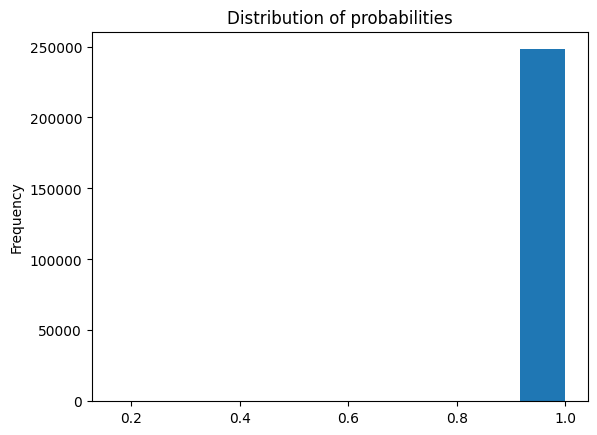

In [29]:
_ = df_comments['PROBABILITY'].astype('float16').plot(kind='hist', title="Distribution of probabilities")

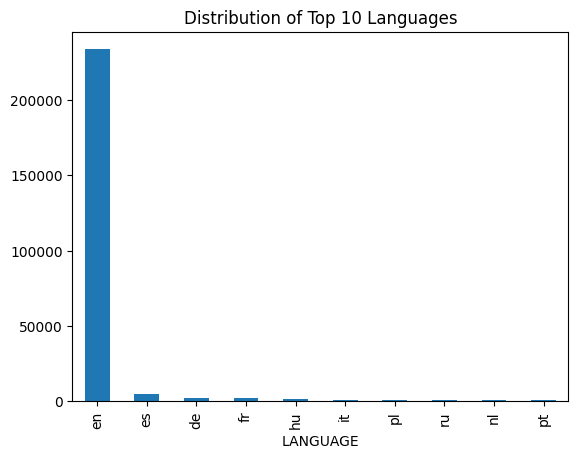

In [30]:
# Distribution of languages
_ = df_comments['LANGUAGE'].value_counts()[:10].plot(kind='bar', title='Distribution of Top 10 Languages')

In [31]:
non_eng = df_comments.query('LANGUAGE != "en"')
print(f"Non-English Comments Perc: {non_eng.shape[0]/df_comments.shape[0]:.2f}")

Non-English Comments Perc: 0.06


Since they are very low in numbers they will be removed 

In [32]:
df_comments = df_comments[df_comments['LANGUAGE'].isin(['en'])]

In [33]:
df_comments.to_csv('../data/interim/english_comments.csv')

## 2.2 Text Analysis

In [34]:
# Add ranking to the comments DataFrame
df_comments = pd.merge(df_comments, df.reset_index()[['TITLE', 'BOARD_GAME_RANK']], how='left', on='TITLE')
df_comments['BOARD_GAME_RANK'] = df_comments['BOARD_GAME_RANK'].astype('int')

In [37]:
print('Comment count statistics: ')
df_comments.groupby('TITLE')['COMMENT'].count().agg(['min', 'mean', 'median', 'max'])

Comment count statistics: 


min         347.00
mean       2336.88
median     1757.00
max       11388.00
Name: COMMENT, dtype: float64

### 2.2.1 Game - Comment 

<Axes: title={'center': 'Comment Counts (Ordered by Rank)'}, ylabel='TITLE'>

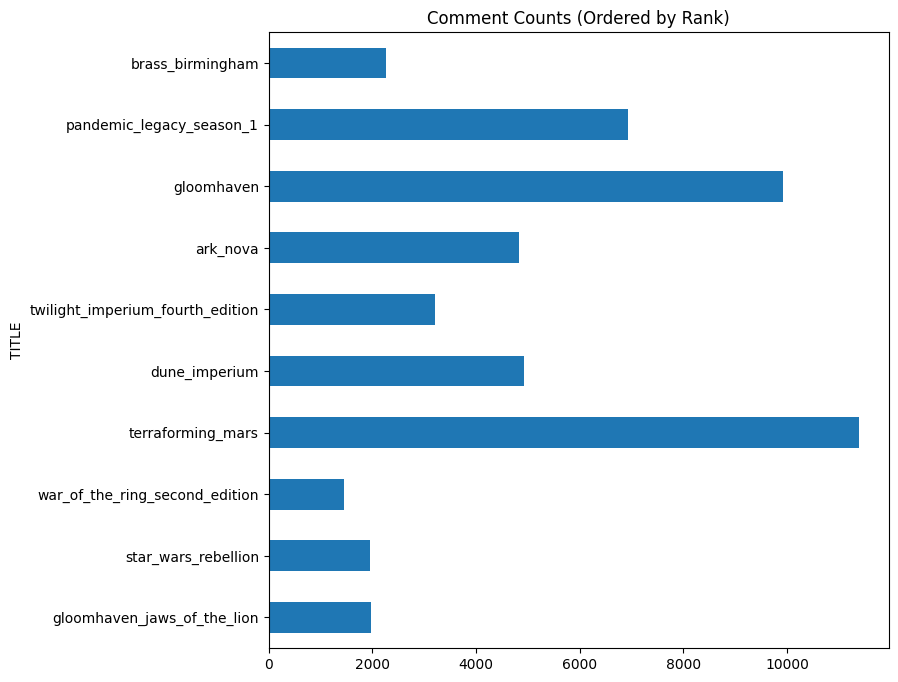

In [38]:
(
    df_comments
    .groupby('TITLE')
    .aggregate({'COMMENT':'count', 'BOARD_GAME_RANK':'min'})
    .sort_values(by='BOARD_GAME_RANK', ascending=False)
    .COMMENT
    .iloc[-10:]
    .plot(kind='barh', title="Comment Counts (Ordered by Rank)", figsize=(8,8))
)

<Axes: title={'center': 'Comment Count Distribution'}, ylabel='Frequency'>

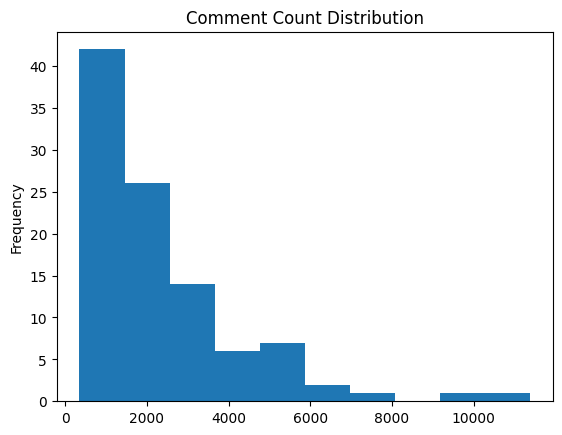

In [39]:
(
    df_comments
    .groupby('TITLE')
    .count()
    .COMMENT
    .plot(kind='hist', title="Comment Count Distribution")
)

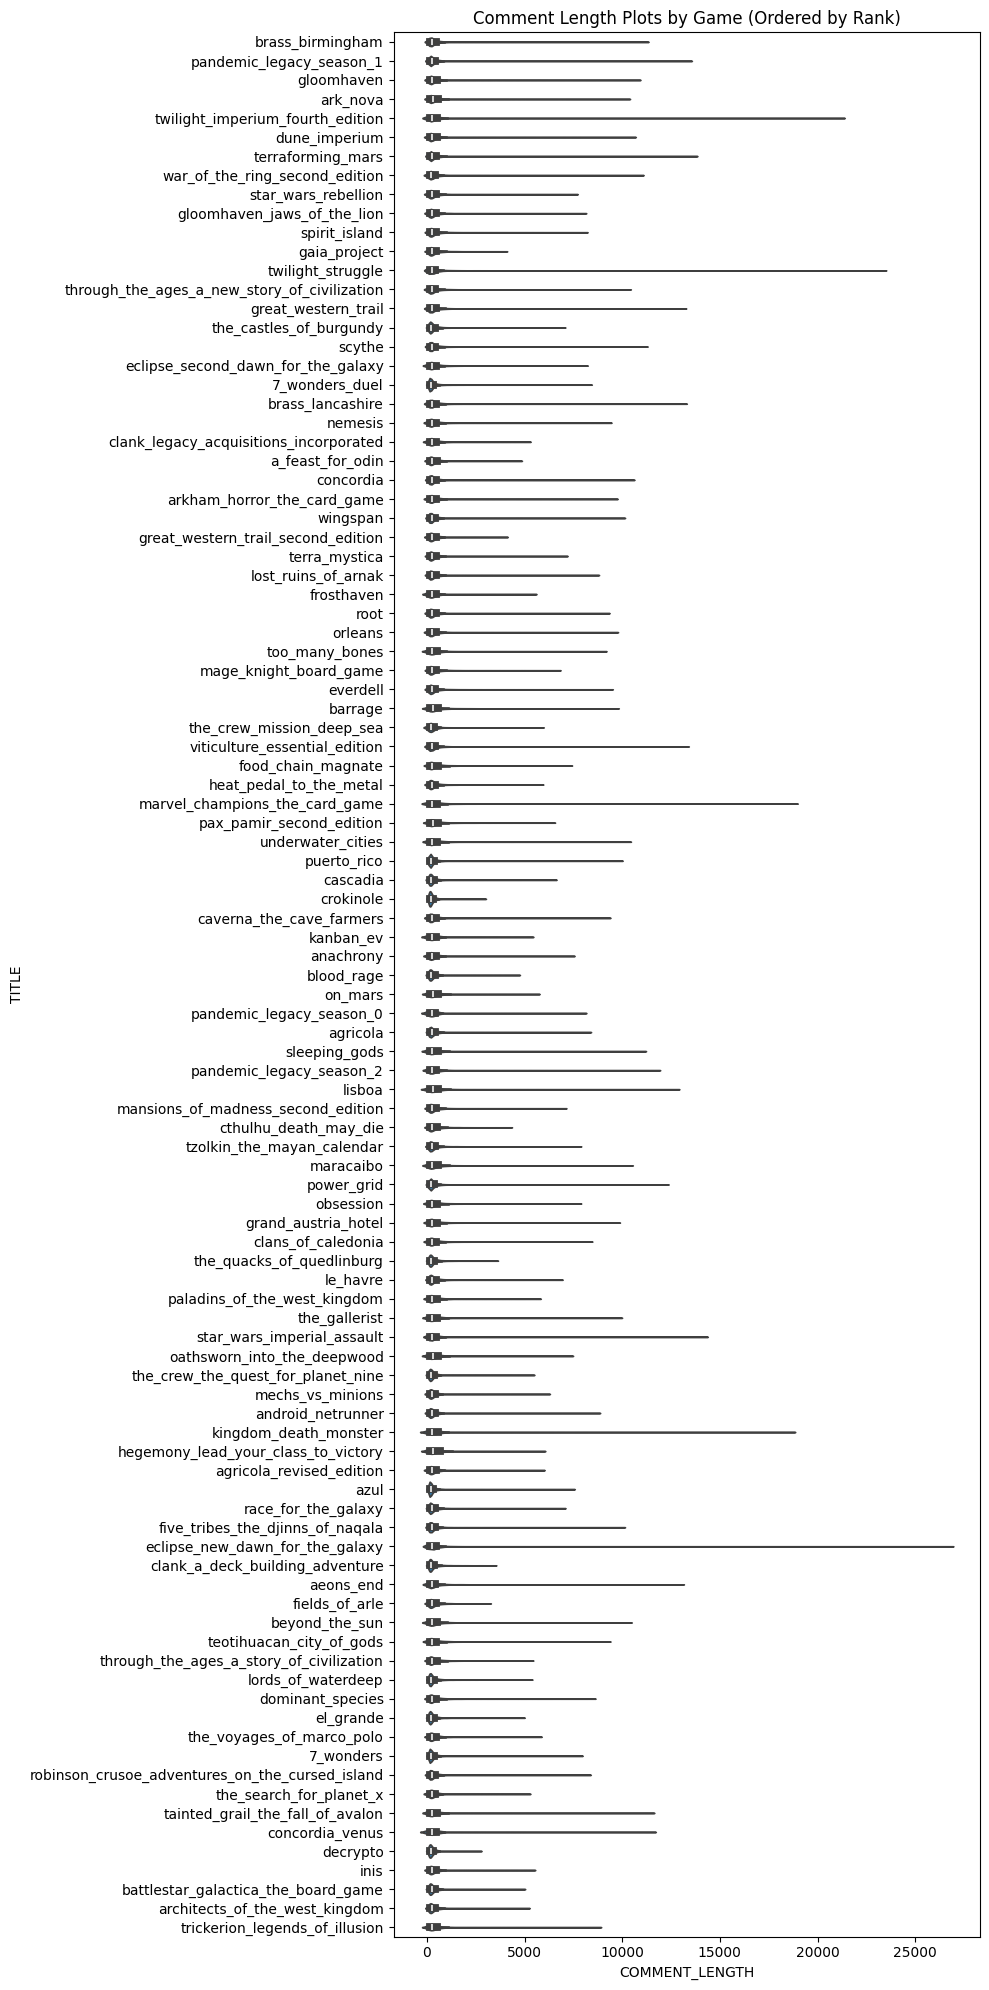

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 20))

s = (
    df_comments
    .assign(COMMENT_LENGTH = lambda x: x['COMMENT'].str.len())
    .groupby('TITLE')
    .aggregate({'COMMENT_LENGTH': list, 'BOARD_GAME_RANK':'min'})
    .sort_values(by='BOARD_GAME_RANK', ascending=True)
    .COMMENT_LENGTH
    .explode()
)

sns.violinplot(data=pd.DataFrame(s), y='TITLE', x='COMMENT_LENGTH') 
plt.title("Comment Length Plots by Game (Ordered by Rank)")
plt.tight_layout()

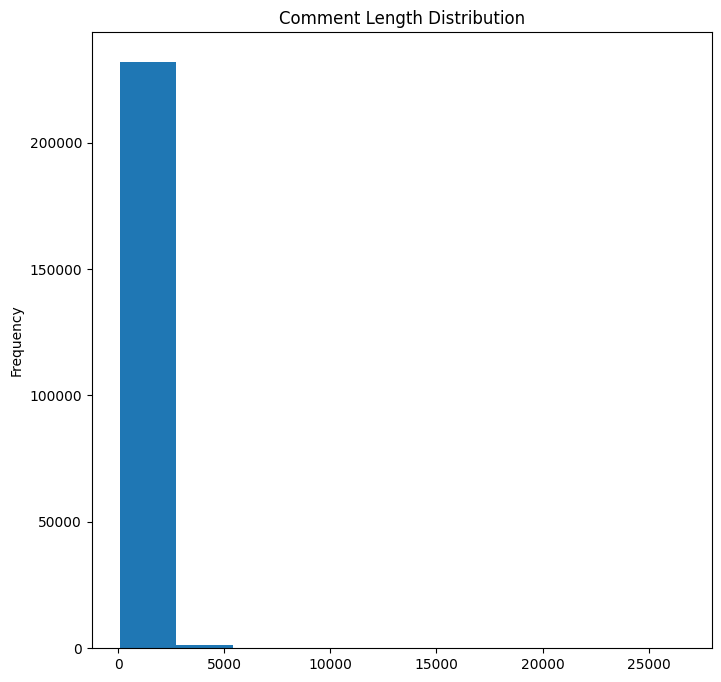

In [51]:
_ = (
    df_comments['COMMENT']
    .str.len()
    .plot(
        kind='hist',
        title='Comment Length Distribution',
        figsize=(8, 8)
    )
)

### 2.2.2 Token Count

In [49]:
import tiktoken
encoding = tiktoken.get_encoding("cl100k_base")

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    with open('../src/config/aspect_extractor.prompt', 'r') as f:
        system_prompt = f.read()
    encoding = tiktoken.encoding_for_model(encoding_name)
    num_tokens = len(encoding.encode(system_prompt + string))
    return num_tokens

In [50]:
total_num_tokens = df_comments['COMMENT'].apply(lambda x: num_tokens_from_string(x, 'gpt-3.5-turbo')).sum()
print(f"Total Number of Tokens for GPT-3.5: {total_num_tokens:,}")

Total Number of Tokens for GPT-3.5: 331,914,336


# 3. Aspect - Category Labelization

In [2]:
import os
import pandas as pd

In [3]:
path = '../data/processed/random_game_comments/'
labeled_csvs = os.listdir(path)
for i, file in enumerate(labeled_csvs):
    if i == 0:
        df_labeled = pd.read_csv(path + file)
    else:
        df_temp = pd.read_csv(path + file)
        df_labeled = pd.concat([df_labeled, df_temp])

In [4]:
df_labeled.head()

,COMMENT,LABELS
0,"""Awesome game for a play through. Good success...","[[BOOKKEEPING], [COMPLEX]]"
1,"""Tentative rating of 8 after 2 plays and still...","[[LUCK], [COMPLEX]]"
2,"""Fantastic, well thought out, evolving play wi...",[[COMPLEX]]
3,"""A fantastic spin on the traditional Pandemic ...",[[COMPLEX]]
4,"""Solid co-op campaign for players who likes Pa...","[[BOOKKEEPING], [COMPLEX]]"


In [5]:
def idx_extractor(string, labels):
    for l in labels:
        search = string.find(l)
        if search != -1:
            return l
        else:
            continue


aspects = ['LUCK', 'BOOKKEEPING', 'DOWNTIME', 'INTERACTION', 'BASH THE LEADER']
categories = ['COMPLICATED', 'COMPLEX']

df_labeled['ASPECT_ENCODES'] = df_labeled.LABELS.apply(lambda x: idx_extractor(x, aspects))
df_labeled['CATEGORY_ENCODES'] = df_labeled.LABELS.apply(lambda x: idx_extractor(x, categories))

In [6]:
df_labeled.head()

,COMMENT,LABELS,ASPECT_ENCODES,CATEGORY_ENCODES
0,"""Awesome game for a play through. Good success...","[[BOOKKEEPING], [COMPLEX]]",BOOKKEEPING,COMPLEX
1,"""Tentative rating of 8 after 2 plays and still...","[[LUCK], [COMPLEX]]",LUCK,COMPLEX
2,"""Fantastic, well thought out, evolving play wi...",[[COMPLEX]],None,COMPLEX
3,"""A fantastic spin on the traditional Pandemic ...",[[COMPLEX]],None,COMPLEX
4,"""Solid co-op campaign for players who likes Pa...","[[BOOKKEEPING], [COMPLEX]]",BOOKKEEPING,COMPLEX


<Axes: title={'center': 'LLM Extracted Aspect Distribution'}>

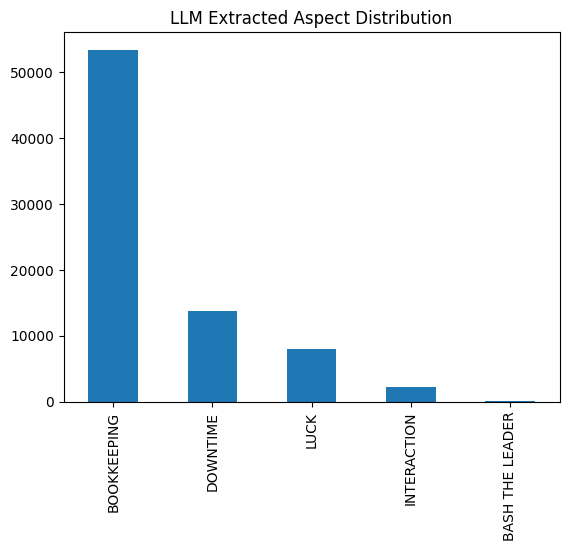

In [122]:
(
    df_labeled
    .ASPECT_ENCODES
    .value_counts()
    .plot(kind='bar', title='LLM Extracted Aspect Distribution', xlabel='')
)

<Axes: title={'center': 'LLM Extracted Category Distribution'}>

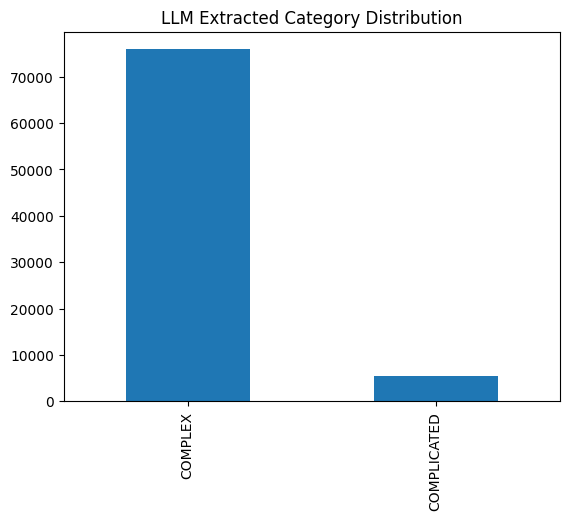

In [123]:
(
    df_labeled
    .CATEGORY_ENCODES
    .value_counts()
    .plot(kind='bar', title='LLM Extracted Category Distribution', xlabel='')
)